In [1]:
# Step 1: installazione delle librerie necessarie
!pip uninstall transformers -y
!pip uninstall accelerate -y
!pip install transformers[torch]
!pip install accelerate -U
!pip install aiohttp
!pip install datasets
!pip install torch

# Step 2: Importazione delle librerie
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import json
import re
from tqdm import tqdm

Found existing installation: transformers 4.41.2
Uninstalling transformers-4.41.2:
  Successfully uninstalled transformers-4.41.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 14.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# GET THE DATASET DIVERSEVUL
f = open('/content/drive/MyDrive/DiverseVul.VulnerableCode.json')
data = json.load(f)
dv = pd.DataFrame(data)
#dv.drop(['_id', 'cwe','project','size'], axis='columns', inplace=True)
dv.info()
dv.groupby('target').describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330492 entries, 0 to 330491
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   _id      330492 non-null  object
 1   func     330492 non-null  object
 2   target   330492 non-null  int64 
 3   cwe      330492 non-null  object
 4   project  330492 non-null  object
 5   size     330492 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 15.1+ MB


size                                                         
           count        mean         std  min   25%   50%    75%      max
target                                                                   
0       311547.0   39.257531  104.818767  1.0   8.0  18.0   40.0  24047.0
1        18945.0  114.707786  312.548557  1.0  22.0  50.0  113.0  23939.0

In [5]:
import re
import pandas as pd
from tqdm import tqdm

def remove_comments(code):
    # Rimuovi commenti su una sola riga
    code = re.sub(r'//.*', '', code)
    # Rimuovi commenti su più righe
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
    return code

def remove_includes_defines(code):
    # Rimuovi include
    code = re.sub(r'#include\s*".*?"', '', code)
    # Rimuovi define
    code = re.sub(r'#define.*', '', code)
    return code

def remove_string(f):
  # f is a string
	# This function removes printed strings: "..."
	f = re.sub("[\"]+(.)+[\"]","\"STR\"",f)
	return f

# Supponiamo che il DataFrame originale si chiami df
df = dv.copy()

# Liste per i nuovi valori
n_tokens, new_strings = [], []

for i in tqdm(range(len(df))):
    file_string = df['func'].iloc[i]
    # Calcola il numero di token prima del preprocessing
    n_tokens.append(len(file_string.split()))
    # Applica le funzioni di preprocessing
    file_string = remove_comments(remove_includes_defines(remove_string(file_string)))
    new_strings.append(file_string)

# Aggiungi le nuove colonne al DataFrame
df['lengths'] = n_tokens
df['func'] = new_strings
df = df[df['lengths']>=5  ]
df = df[df['lengths']<=256]
df.sort_values('lengths')
df = df.drop(['lengths'], axis=1)
df = df.reset_index(drop=True)

df

100%|██████████| 330492/330492 [00:19<00:00, 16860.90it/s]


,_id,func,target,cwe,project,size
0,{'$oid': '6527b17399826ba7e58eb15c'},static void cirrus_invalidate_region(CirrusVGA...,1,[CWE-787],qemu,19
1,{'$oid': '6527b17399826ba7e58eb176'},static int pwc_video_close(struct inode *inode...,1,[CWE-399],linux-2.6,42
2,{'$oid': '6527b17399826ba7e58eb175'},"static int putreg(struct task_struct *child,\n...",1,[CWE-264],linux-2.6,60
3,{'$oid': '6527b17399826ba7e58eb160'},static void cirrus_mem_writeb_mode4and5_16bpp(...,1,[CWE-787],qemu,24
4,{'$oid': '6527b17399826ba7e58eb168'},"static int fat_dir_ioctl(struct inode * inode,...",1,[],linux-2.6,44
...,...,...,...,...,...,...
291422,{'$oid': '6527b2fa99826ba7e593bc18'},"auth_passdb_preinit(struct auth *auth, const s...",0,[CWE-284],core,56
291423,{'$oid': '6527b2fa99826ba7e593bc1c'},"int CMS_data(CMS_ContentInfo *cms, BIO *out, u...",0,"[CWE-399, CWE-703]",openssl,16
291424,{'$oid': '6527b2fa99826ba7e593bc29'},static int cms_kari_set1_pkey(CMS_ContentInfo ...,0,"[CWE-399, CWE-703]",openssl,24
291425,{'$oid': '6527b2fa99826ba7e593bc2b'},static int cms_signerinfo_verify_cert(CMS_Sign...,0,"[CWE-399, CWE-703]",openssl,36


In [6]:
union = df.copy()
vv = df[df['target']==1]
nv = df[df['target']==0].sample(n=len(df[df['target']==1]))
union = pd.concat([vv,nv])
union = union.sample(frac = 1)
union = union.reset_index(drop=True)
union

,_id,func,target,cwe,project,size
0,{'$oid': '6527b1c199826ba7e58f838e'},static void bdrv_vhdx_init(void)\n{\n bdrv_...,0,[CWE-835],qemu,4
1,{'$oid': '6527b20c99826ba7e5907954'},\nstatic inline void skb_clear_hash_if_not_l4(...,0,[CWE-20],linux,5
2,{'$oid': '6527b18f99826ba7e58ee4f2'},"void CLASS panasonic_load_raw()\n{\n int row,...",1,"[CWE-119, CWE-125]",LibRaw,32
3,{'$oid': '6527b29799826ba7e5924ab9'},\nstatic inline void io_file_bitmap_clear(stru...,0,[CWE-416],linux,5
4,{'$oid': '6527b17c99826ba7e58ec6c5'},static inline void ModulateHSL(const double pe...,1,[CWE-835],ImageMagick,22
...,...,...,...,...,...,...
25057,{'$oid': '6527b19799826ba7e58ef664'},"rsvg_paint_server_parse (gboolean * inherit, c...",1,[],librsvg,39
25058,{'$oid': '6527b18899826ba7e58ed8e8'},"void luaT_adjustvarargs (lua_State *L, int nfi...",1,"[CWE-416, CWE-125, CWE-787]",lua,18
25059,{'$oid': '6527b1b099826ba7e58f47a8'},"static int ep_loop_check(struct eventpoll *ep,...",0,[],linux-2.6,15
25060,{'$oid': '6527b19799826ba7e58ef512'},"mm_answer_pam_free_ctx(int sock, Buffer *m)\n{...",1,"[CWE-284, CWE-264]",openssh-portable,11


In [7]:
df=union.copy()
# SPLIT IN 3 SET AND STRATITY
df_v = df[df['target']==1]
split1 = int(len(df_v)*0.9)
split2 = int(len(df_v)*0.95)
df_v_train= df_v[:split1]
df_v_valid= df_v[split1:split2]
df_v_test = df_v[split2:]

df_n = df[df['target']==0]
split1 = int(len(df_n)*0.9)
split2 = int(len(df_n)*0.95)
df_n_train= df_n[:split1]
df_n_valid= df_n[split1:split2]
df_n_test = df_n[split2:]

# MERGE AND SHUFFLE ITEMS
df_train = pd.concat([df_v_train,df_n_train])
df_train = df_train.sample(frac = 1)
df_valid = pd.concat([df_v_valid,df_n_valid])
df_valid = df_valid.sample(frac = 1)
df_test  = pd.concat([df_v_test, df_n_test])
df_test  = df_test.sample(frac = 1)

print("TOTAL:",len(df))

print("TRAIN VUL    :",len(df_train[df_train['target']==0]))
print("TRAIN NON VUL:",len(df_train[df_train['target']==1]))
print("VALID VUL    :",len(df_valid[df_valid['target']==0]))
print("VALID NON VUL:",len(df_valid[df_valid['target']==1]))
print("TEST VUL     :",len(df_test[df_test['target']==0]))
print("TEST NON VUL :",len(df_test[df_test['target']==1]))

TOTAL: 25062
TRAIN VUL    : 11277
TRAIN NON VUL: 11277
VALID VUL    : 627
VALID NON VUL: 627
TEST VUL     : 627
TEST NON VUL : 627


In [8]:
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_valid)
test_dataset = Dataset.from_pandas(df_test)

In [11]:
# Step 4: Tokenizzazione
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-small")

def preprocess_function(examples):
    # Tokenizza i dati e includi le etichette (labels)
    inputs = tokenizer(examples['func'], truncation=True, padding='max_length', max_length=256)
    inputs['labels'] = examples['target']
    return inputs

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Step 5: Caricamento del modello
model = AutoModelForSequenceClassification.from_pretrained("Salesforce/codet5-small", num_labels=2)

# Step 6: Definizione degli argomenti di addestramento
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
)

# Step 7: Definizione del Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Utilizza il set di validazione
)



Map:   0%|          | 0/22554 [00:00<?, ? examples/s]

Map:   0%|          | 0/1254 [00:00<?, ? examples/s]

Map:   0%|          | 0/1254 [00:00<?, ? examples/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at Salesforce/codet5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
# Step 8: Addestramento del modello
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.654900,0.623184
2,0.614900,0.601818
3,0.576100,0.594781
4,0.529700,0.617761
5,0.495900,0.620426
6,0.439600,0.692444
7,0.417800,0.700234
8,0.391700,0.749255


TrainOutput(global_step=22560, training_loss=0.5136463438365476, metrics={'train_runtime': 6172.3361, 'train_samples_per_second': 29.232, 'train_steps_per_second': 3.655, 'total_flos': 1.2283073727676416e+16, 'train_loss': 0.5136463438365476, 'epoch': 8.0})

In [13]:

# Step 9: Valutazione del modello
results = trainer.evaluate(eval_dataset=test_dataset)  # Utilizza il set di test per la valutazione finale
print(results)

{'eval_loss': 0.7329797148704529, 'eval_runtime': 12.47, 'eval_samples_per_second': 100.562, 'eval_steps_per_second': 12.59, 'epoch': 8.0}


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.69      0.70       627
           1       0.70      0.73      0.72       627

    accuracy                           0.71      1254
   macro avg       0.71      0.71      0.71      1254
weighted avg       0.71      0.71      0.71      1254



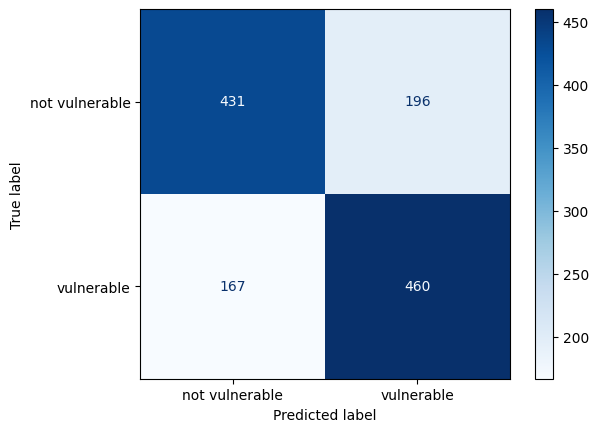

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Step 10: Valutazione del modello su set di test
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions[0], axis=1)  # Accessing the logits

true_labels = test_dataset['labels']

# Step 11: Stampa del classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

target_names = ['not vulnerable', 'vulnerable']

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizza la matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

